In [18]:
# Imports

%pylab inline

import torch
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch import nn, optim
from torch.distributions import Normal, Laplace, Independent, Bernoulli, Gamma, Uniform, Beta
from torch.distributions.kl import kl_divergence

Populating the interactive namespace from numpy and matplotlib


In [19]:
# Load the MNIST training and test sets

def load_data(batch_size):
    train_data = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size, shuffle=True, **{})

    test_data = datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})
    return train_data, train_loader, test_data, test_loader

In [20]:
# Distribution namespaces

def normal_dist(mu, var):
    return Normal(loc=mu, scale=var)

def laplace_dist(mu, var):
    return Laplace(loc=mu, scale=var)

def gamma_dist(mu, var):
    return Gamma(concentration=mu, rate=var)

def beta_dist(mu, var):
    return Beta(concentration1=mu, concentration0=var)

def bernoulli_loss(x_hat):
    return Bernoulli(x_hat)

def laplace_loss(x_hat, scale=0.05):
    return Laplace(loc=x_hat, scale=scale)

In [224]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)


class VAE(nn.Module):
    def __init__(self, conv_encoder, linear_encoder, decoder, loss_dist, p_x_dist, q_z_dist):
        super(VAE, self).__init__()
        self.conv_encoder = nn.Sequential(*conv_encoder)
        self.linear_encoder = nn.Sequential(*linear_encoder)
        self.decoder = nn.Sequential(*decoder)
        self.p_x_dist = p_x_dist
        self.q_z_dist = q_z_dist
        self.loss_dist = loss_dist

    def encode(self, x):
        # First go through the convolutional layers
        output = self.conv_encoder(x)
        # Flatten the output (TODO: make 4*4*50 a variable that comes from the convolutional layers)
        output = output.view(-1, 4*4*50)
        # Go through the linear layers
        output = self.linear_encoder(output)
        output_len = len(output[0]) // 2
        return output[:,:output_len], output[:,output_len:]

    def reparameterize(self, q_z):
        return q_z.rsample()

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        
        q_z = self.q_z_dist(mu, logvar)
        q_z = Independent(q_z, 1)
        
        z = self.reparameterize(q_z)
        x_hat = self.decode(z)
        
        p_x = self.loss_dist(x_hat)
        loss = self.loss_function(x_hat, x, p_x, q_z, z)
        
        return x_hat, loss
    
    def loss_function(self, x_hat, x, p_x, q_z, z):
        x = x.view(-1, x_dim)
        BCE = torch.sum(-p_x.log_prob(x))
        KLD = kl_divergence(q_z.base_dist, self.p_x_dist.base_dist)
        KLD = torch.sum(KLD.sum(len(p_x_dist.event_shape)-1))
        
        return BCE + KLD

In [192]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        x_hat, loss = model(data)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, batch_size):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data
            x_hat, loss = model(data)
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      x_hat.view(batch_size, 1, 28, 28)[:n]])

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [220]:
x_dim = 784
z_dim = 2

lr = 1e-3 # Learning rate
batch_size = 64
epochs = 25


# Prior distribution
p_x_dist = Beta(torch.tensor([0.5, 0.5]), torch.tensor([0.5, 0.5]))
p_x_dist = Independent(p_x_dist, 1)

# Target distribution
q_z_dist = beta_dist

# Loss distribution
loss_dist = bernoulli_loss

conv_encoder_layers = [
    nn.Conv2d(1, 20, 5, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(20, 50, 5, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2)
    ]

linear_encoder_layers = [
    nn.Linear(50*4*4, 392),
    nn.ReLU(True),
    nn.Linear(392, 196),
    nn.ReLU(True),
    nn.Linear(196, 49),
    nn.ReLU(True),
    nn.Linear(49, z_dim*2),
    nn.Softplus()
    ]

decoder_layers = [
    nn.Linear(z_dim, 49),
    nn.ReLU(True),
    nn.Linear(49, 196),
    nn.ReLU(True),
    nn.Linear(196, 392),
    nn.ReLU(True),
    nn.Linear(392, x_dim),
    nn.Sigmoid()
    ]

# Load the MNIST data
train_data, train_loader, test_data, test_loader = load_data(batch_size)

# Create the model
model = VAE(conv_encoder=conv_encoder_layers, linear_encoder=linear_encoder_layers,
            decoder=decoder_layers, p_x_dist=p_x_dist, q_z_dist=q_z_dist, loss_dist=loss_dist)

optimizer = optim.Adam(model.parameters(), lr=lr)

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch, batch_size)
        # collection_image(epoch)        

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.584595
Train Epoch: 1 [6400/60000 (11%)]	Loss: 206.505585
Train Epoch: 1 [12800/60000 (21%)]	Loss: 193.248093
Train Epoch: 1 [19200/60000 (32%)]	Loss: 189.549728
Train Epoch: 1 [25600/60000 (43%)]	Loss: 204.625595
Train Epoch: 1 [32000/60000 (53%)]	Loss: 186.836212
Train Epoch: 1 [38400/60000 (64%)]	Loss: 189.931076
Train Epoch: 1 [44800/60000 (75%)]	Loss: 195.311981
Train Epoch: 1 [51200/60000 (85%)]	Loss: 187.623672
Train Epoch: 1 [57600/60000 (96%)]	Loss: 178.185745
====> Epoch: 1 Average loss: 195.1288
====> Test set loss: 174.7878
Train Epoch: 2 [0/60000 (0%)]	Loss: 170.289841
Train Epoch: 2 [6400/60000 (11%)]	Loss: 180.567459
Train Epoch: 2 [12800/60000 (21%)]	Loss: 168.051834
Train Epoch: 2 [19200/60000 (32%)]	Loss: 174.523041
Train Epoch: 2 [25600/60000 (43%)]	Loss: 176.992172
Train Epoch: 2 [32000/60000 (53%)]	Loss: 163.145538
Train Epoch: 2 [38400/60000 (64%)]	Loss: 158.568497
Train Epoch: 2 [44800/60000 (75%)]	Loss: 163.529282
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 145.868225
Train Epoch: 15 [12800/60000 (21%)]	Loss: 138.159485
Train Epoch: 15 [19200/60000 (32%)]	Loss: 143.764725
Train Epoch: 15 [25600/60000 (43%)]	Loss: 140.197357
Train Epoch: 15 [32000/60000 (53%)]	Loss: 141.800232
Train Epoch: 15 [38400/60000 (64%)]	Loss: 139.621109
Train Epoch: 15 [44800/60000 (75%)]	Loss: 136.911682
Train Epoch: 15 [51200/60000 (85%)]	Loss: 128.922546
Train Epoch: 15 [57600/60000 (96%)]	Loss: 141.572769
====> Epoch: 15 Average loss: 144.2818
====> Test set loss: 143.7547
Train Epoch: 16 [0/60000 (0%)]	Loss: 145.810135
Train Epoch: 16 [6400/60000 (11%)]	Loss: 146.538452
Train Epoch: 16 [12800/60000 (21%)]	Loss: 146.886887
Train Epoch: 16 [19200/60000 (32%)]	Loss: 136.327103
Train Epoch: 16 [25600/60000 (43%)]	Loss: 140.165192
Train Epoch: 16 [32000/60000 (53%)]	Loss: 159.167786
Train Epoch: 16 [38400/60000 (64%)]	Loss: 148.057709
Train Epoch: 16 [44800/60000 (75%)]	Loss: 144.937500
Train Epoch: 16 [51200/60000 (85%)]	L

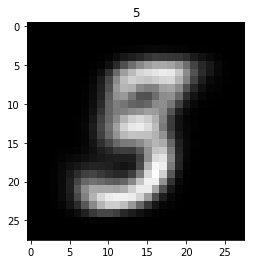

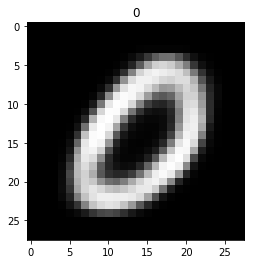

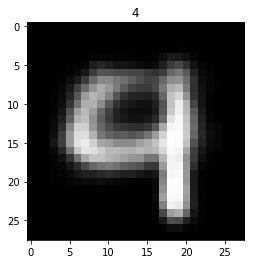

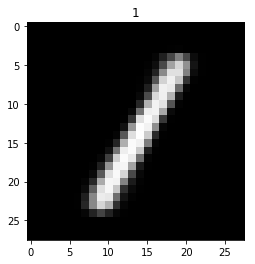

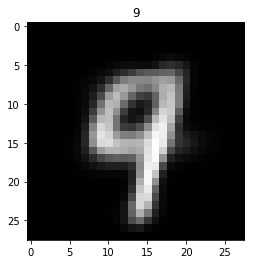

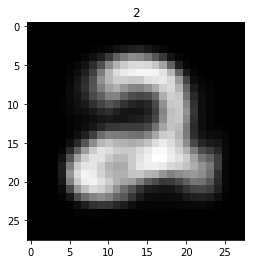

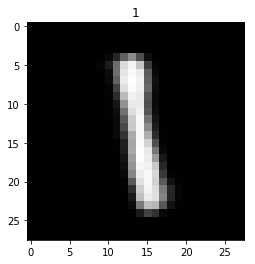

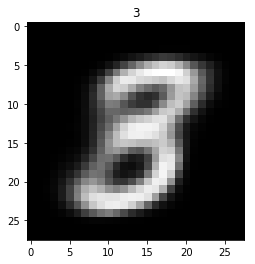

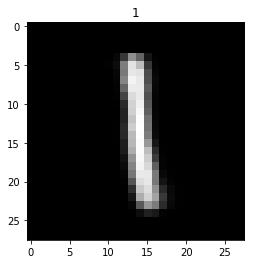

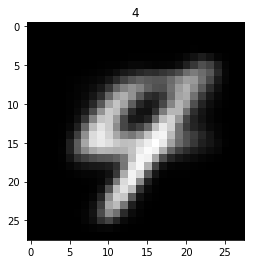

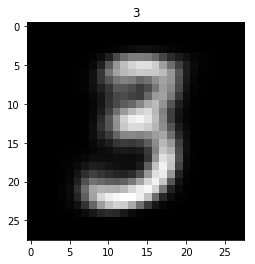

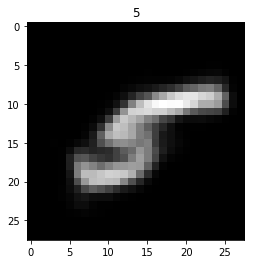

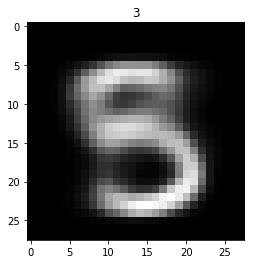

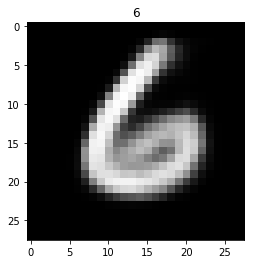

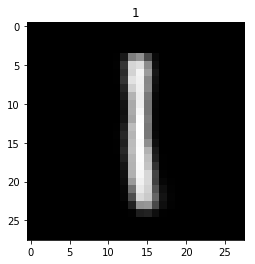

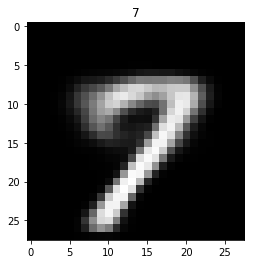

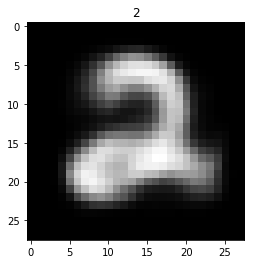

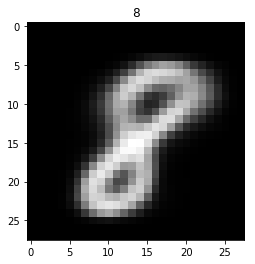

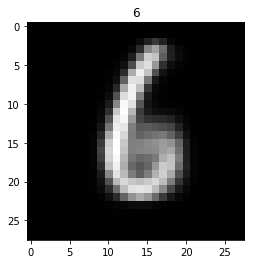

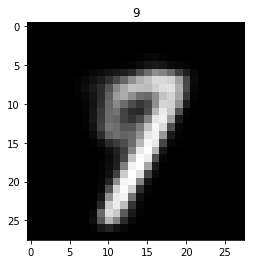

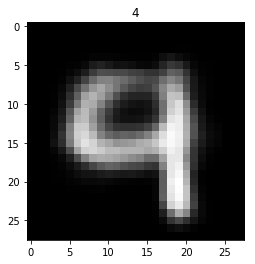

In [223]:
### Let's check if the reconstructions make sense
# Set model to test mode
model.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu = model(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 20:
        break


In [149]:
from torchvision.utils import save_image

def collection_image(epoch):
    xv = np.arange(0, 1, .04)
    yv = np.arange(0, 1, .04)
    sample = np.zeros([len(yv)*len(xv), 2])
    counter = 0
    for i, j in zip(xv, yv):
        for j in yv:
            sample[counter] = [i, j]
            counter += 1

    images = model.decode(torch.tensor(sample, dtype=torch.float)).detach().numpy()
    image = np.zeros([len(xv)*28, len(yv)*28])
    counter = 0
    for i in range(len(xv)):
        for j in range(len(yv)):
            image[i*28:i*28+28,j*28:j*28+28] = images[counter].reshape((28,28))
            counter += 1

    save_image(torch.tensor(image),'personal/results/laplace/sample_norm_' + str(epoch) + '.png')